# Genomic Analysis of the DiGeorge Syndrome Region on Chromosome 22

DiGeorge Syndrome, also known as 22q11.2 deletion syndrome, is a genetic disorder caused by a deletion of a small segment on chromosome 22. This region, located between positions 18,800,000 and 21,400,000, is critical for normal development, and its deletion can lead to a range of symptoms including heart defects, immune system abnormalities, and developmental delays.

In this notebook, I'll focus on the genomic variants present within the 22q11.2 region using data from the 1000 Genomes Project. The aim is to identify and analyze these variants to better understand their role in the development of DiGeorge Syndrome.

This notebook sets up the environment for working with large genomic datasets, explores the variants in the region of interest, and performs various analyses, including the identification of common and rare variants. As the analysis progresses, I'll dive deeper into the biological implications of the findings.

## Step 1: Environment Setup and Data Loading

In this section, I'll configure the computational environment required to handle large genomic datasets. This includes setting up Spark, a powerful tool for distributed computing, which will allow us to efficiently process the variant data from the 1000 Genomes Project.


### Step 1.1: Installing Dependencies

To begin working with the genomic data, we need to ensure that all necessary libraries and tools are installed. This includes tools for handling large datasets (such as PySpark) and various bioinformatics utilities that will assist us in processing and analyzing the genomic variants.

These dependencies will allow us to manage the data efficiently, perform calculations on distributed systems, and carry out further analyses on the genetic variants associated with DiGeorge Syndrome.


In [48]:
#!pip install colorama executing beautifulsoup4 requests

In [49]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt

# Install pyspark 3.3.2
!pip install pyspark==3.3.2
from pyspark.sql.functions import explode, col

# Set up the environment for Spark and other necessary tools
# Install Java 11 (compatible with Spark 3.3.2)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Configure Spark environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.10/dist-packages/pyspark"


In [50]:
# Download libraries from Hadoop and AWS
!wget -q https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.1/hadoop-aws-3.3.1.jar
!wget -q https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.374/aws-java-sdk-bundle-1.12.374.jar

# Move libraries to Spark directory
!mv hadoop-aws-3.3.1.jar $SPARK_HOME/jars/
!mv aws-java-sdk-bundle-1.12.374.jar $SPARK_HOME/jars/


#### BioPerl: Tools for Bioinformatics in Perl

**BioPerl** is a collection of Perl modules designed to facilitate the development of bioinformatics applications. These modules provide tools for common tasks in biological data processing, such as:

- **Sequence Manipulation**: Reading, writing, and converting between different sequence formats (FASTA, GenBank, EMBL, etc.).
- **Sequence Analysis**: Performing alignments, pattern searches, and handling annotations.
- **Access to Biological Databases**: Interacting with public databases like GenBank, SwissProt, and PDB, making it easier to download and process biological data.
- **Structure Handling**: Support for handling protein and nucleic acid structures.

In [51]:
# Install Perl and necessary dependencies
!apt-get update
!apt-get install -y libxml2-dev libexpat1-dev libssl-dev libgd-dev libncurses5-dev zlib1g-dev libbz2-dev \
liblzma-dev libmysqlclient-dev libcurl4-openssl-dev build-essential

# Install cpanminus and BioPerl
!apt-get install -y cpanminus
!cpanm Bio::Perl

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,499 kB]
Get:14 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,438 kB]
Fetched 4,194 kB in 4s (1,004 kB/s)
Rea

### Step 1.2: Configure Spark


In [52]:
from pyspark.sql import SparkSession
# Initiate Spark Session with detailed configuration
spark = SparkSession.builder \
    .appName("1000Genomes") \
    .config("spark.jars.packages",
            "org.apache.hadoop:hadoop-aws:3.3.6,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.565,"
            "io.projectglow:glow-spark3_2.12:1.1.1") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Verify Spark session
print("Spark Session created:", spark)
print("Spark Version:", spark.version)
print("Spark App Name:", spark.sparkContext.appName)
print("Spark Master:", spark.sparkContext.master)

Spark Session created: <pyspark.sql.session.SparkSession object at 0x7bad986b9b10>
Spark Version: 3.3.2
Spark App Name: 1000Genomes
Spark Master: local[*]



## Step 2: Load and filter the VCF Data

The data I'll work with comes from a VCF (Variant Call Format) file, which contains genomic variants for chromosome 22. This file includes key information such as the position of each variant, the type of variant (SNP, INDEL, structural variants), and the frequency of the alleles.

I'll first load the entire dataset and then filter it to focus on the region of chromosome 22 (positions 18,800,000 to 21,400,000) associated with DiGeorge Syndrome. This allows us to narrow our analysis to the region most relevant for the syndrome, ensuring that our findings are biologically meaningful.


In [53]:
# Define the file paths
vcf_url = "https://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
vcf_gz_path = "/content/output.vcf.gz"
vcf_path = "/content/output.vcf"

try:
    # Check if the VCF file has already been downloaded
    if not os.path.exists(vcf_path):
        print("VCF file not found, downloading...")
        !wget -q -O {vcf_gz_path} {vcf_url}

        # Unzip VCF file if the download was successful
        if os.path.exists(vcf_gz_path):
            print("Unzipping VCF file...")
            !gunzip {vcf_gz_path}
        else:
            raise FileNotFoundError(f"Downloaded file {vcf_gz_path} was not found.")

    else:
        print("VCF file already exists, skipping download and extraction.")

except Exception as e:
    print(f"An error occurred: {e}")

VCF file already exists, skipping download and extraction.


In [54]:
vcf_path = "/content/output.vcf"
vcf_df = spark.read.format("vcf").load(vcf_path)

vcf_df.show(10)

+----------+--------+--------+--------------------+---------------+--------------------+-----+-------+---------------------+---------+----------------+----------+-------+--------------------+-------+-------+------------------+--------------------+----------+-------+--------------------+--------------------+--------------------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+--------------------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|               names|referenceAllele|    alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|         INFO_AC|INFO_CIEND|INFO_NS|         INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|         INFO_SAS_AF|INFO_CIPOS|INFO_AA|             INFO_AF|         INFO_EAS_AF|         INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|         INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes

In [55]:
#Understand the dataset schema
vcf_df.printSchema()

root
 |-- contigName: string (nullable = true)
 |-- start: long (nullable = true)
 |-- end: long (nullable = true)
 |-- names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAlleles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- qual: double (nullable = true)
 |-- filters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- splitFromMultiAllelic: boolean (nullable = true)
 |-- INFO_MEND: integer (nullable = true)
 |-- INFO_AC: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_CIEND: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- INFO_NS: integer (nullable = true)
 |-- INFO_AFR_AF: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- INFO_VT: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- INFO_AN: integer (nullable = true)
 |-- INF

In [56]:
#Count rows to know the number of variants
vcf_df.count()

1103547

In [57]:
# Count the number of variants by type
variant_counts = vcf_df.groupBy("INFO_VT").count().show()

+------------+-------+
|     INFO_VT|  count|
+------------+-------+
|[SNP, INDEL]|    871|
|       [SNP]|1059517|
|        [SV]|    782|
|     [INDEL]|  42377|
+------------+-------+



[SNP]: SNPs are changes in a single nucleotide and are often associated with genetic variation and potential disease risk.
- 1,059,517 variants are Single Nucleotide Polymorphisms.

[INDEL]: These occur when small sequences of DNA are inserted or deleted, potentially disrupting gene function.
- 42,377 variants are insertions or deletions.

[SV]: Larger changes in the structure of the chromosome.
- 782 are Structural Variants.

[SNP, INDEL]: 871 variants are identified as both SNPs and INDELs, which may indicate a complex variant or multiple annotations. These variants could behave as either type depending on the genomic context.

In [58]:
#Remove compressed files to free memory
vcf_gz_path = '/content/output.vcf.gz'
if os.path.exists(vcf_gz_path):
    os.remove(vcf_gz_path)
    print(f"Deleted {vcf_gz_path} to free up space.")
else:
    print(f"{vcf_gz_path} does not exist.")

/content/output.vcf.gz does not exist.


In [59]:
# Filter the DataFrame for variants within the DiGeorge Syndrome region on chromosome 22
df_22q11 = vcf_df.filter(
    (vcf_df.start >= 18800000) &
    (vcf_df.start <= 21400000)
)

# Show the first few rows of the filtered annotated DataFrame
df_22q11.show(10)


+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+--

## Step 3: Variant Analysis and Classification

After loading and filtering the VCF data, I proceed to classify the variants within the region of interest (22q11.2) based on their type. Genomic variants can be classified into different categories such as SNPs (Single Nucleotide Polymorphisms), INDELs (Insertions and Deletions), and structural variants.

Understanding the distribution of these variant types is crucial for identifying potential genetic markers associated with DiGeorge Syndrome. By grouping the variants by type, we can assess which types are most prevalent in this region and may have a higher likelihood of contributing to the genetic predisposition to the syndrome.


In [60]:
# Group by variant type and count the occurrences
df_22q11.groupBy("INFO_VT").count().show()

# Explode the 'alternateAlleles' column to create a row for each alternate allele
#df_22q11 = df_22q11.withColumn("alt", explode(col("alternateAlleles")))

+------------+-----+
|     INFO_VT|count|
+------------+-----+
|[SNP, INDEL]|   52|
|       [SNP]|70262|
|        [SV]|   53|
|     [INDEL]| 2766|
+------------+-----+



The table above shows the distribution of variant types within the 22q11.2 region of chromosome 22:

- **SNPs (Single Nucleotide Polymorphisms)** are the most common type of variant, with a total of 70,262 occurrences.
- **INDELs (Insertions and Deletions)** are less frequent, with 2,766 variants.
- **Structural Variants (SVs)** occur 53 times.
- There are also 52 variants classified as both **SNP and INDEL**.

This distribution highlights that SNPs are by far the most prevalent variant type in this region, which is consistent with the general observation that SNPs are the most common type of genetic variation.

In [61]:
# Explode the 'INFO_AF' column and rename the exploded column to 'AlleleFreq'
df_22q11 = df_22q11.withColumn("AlleleFreq", explode(col("INFO_AF")))

# Describe allele frequencies
df_22q11.select("AlleleFreq").describe().show()

+-------+-------------------+
|summary|         AlleleFreq|
+-------+-------------------+
|  count|              73567|
|   mean|0.03719567752284753|
| stddev|0.13272459033720882|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



The second table summarizes the allele frequencies (AF) of the variants in this region:

- **Count**: There are 73,567 allele frequency values in total, indicating the number of alleles present in the dataset.
- **Mean**: The mean allele frequency is approximately 0.0372. This suggests that, on average, the alleles in this region are rare, as the mean is much lower than 0.5.
- **StdDev (Standard Deviation)**: The standard deviation of 0.133 indicates a wide variation in allele frequencies, with many variants likely being extremely rare (close to 0) and some being more common.
- **Min**: The minimum allele frequency is 0, which suggests that some variants are not present in the population.
- **Max**: The maximum allele frequency is 1, meaning that certain variants are present in all individuals sampled.

This data suggests that most of the variants in this region are rare, which is typical for regions associated with genetic disorders like DiGeorge Syndrome. Rare variants often have a higher impact on disease phenotypes, making them important targets for further analysis.



### Visualize the Allele Frequency Distribution

I'll use a histogram to visualize the distribution of allele frequencies, which will allow us to determine if most rare variants have low frequencies, as expected, or if there is significant variability in their distribution.

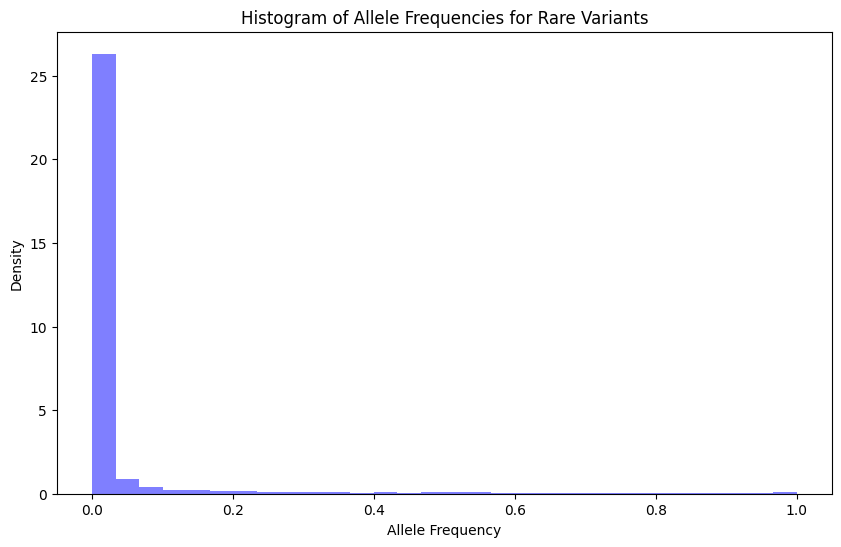

In [62]:
# Convert the DataFrame to a Pandas DataFrame for easier plotting
allele_freqs = df_22q11.select("AlleleFreq").toPandas()

# Plot a histogram of allele frequencies
plt.figure(figsize=(10, 6))
plt.hist(allele_freqs, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Histogram of Allele Frequencies for Rare Variants')
plt.xlabel('Allele Frequency')
plt.ylabel('Counts')
plt.show()

High Peak at Low Frequencies: As expected, most variants have frequencies close to 0, indicating that these variants are extremely rare in the population. These could represent rare variants that might have more significant impacts on individuals.

Sparse High-Frequency Variants: There are very few variants with higher allele frequencies, suggesting that most of the genetic variation in this region consists of rare variants.

## Step 4: Focus on Rare Variants

In this section, I further filter the variants in the 22q11.2 region by focusing on rare variants, defined as those with an allele frequency below 0.05. This threshold allows us to isolate the variants that are less common in the population but may have significant effects on disease susceptibility.

The `INFO_CS` and `INFO_SVTYPE` fields both provide information related to structural variations (SVs) within these variants. However, they offer different perspectives:
- **`INFO_SVTYPE`** categorizes the type of structural variation (e.g., deletions, duplications, insertions), helping to identify the nature of the genomic change.
- **`INFO_CS`** gives additional classification details, often providing the source or further specifying the type of structural variation, such as retrotransposons (e.g., ALU, LINE1, SVA).

By using these fields, we will analyze and visualize the distribution of structural variation types to better understand their potential role in the genetic basis of DiGeorge Syndrome.


In [63]:
# Filter the DataFrame to obtain only rare variants (allele frequency < 0.05).
# This is important because rare variants often have a higher impact on genetic diseases.
rare_variants_df = df_22q11.filter(df_22q11["AlleleFreq"] < 0.05)

# Show the first 10 rows of the filtered DataFrame to verify that the filter was applied correctly.
rare_variants_df.show(10)

+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------+-------+----------+-------+-----------+-------+-------+------------------+-----------+----------+-------+------------+-----------+-----------+-------+----------+---------+-----------+--------------+-------+-------+--------+-----------+-----------+--------------+--------+-----------+--------------------+----------+
|contigName|   start|     end|        names|referenceAllele|alternateAlleles| qual|filters|splitFromMultiAllelic|INFO_MEND|INFO_AC|INFO_CIEND|INFO_NS|INFO_AFR_AF|INFO_VT|INFO_AN|INFO_MULTI_ALLELIC|INFO_SAS_AF|INFO_CIPOS|INFO_AA|     INFO_AF|INFO_EAS_AF|INFO_AMR_AF|INFO_DP|INFO_SVLEN|INFO_MLEN|INFO_MEINFO|INFO_IMPRECISE|INFO_CS|INFO_MC|INFO_END|INFO_MSTART|INFO_EUR_AF|INFO_EX_TARGET|INFO_TSD|INFO_SVTYPE|           genotypes|AlleleFreq|
+----------+--------+--------+-------------+---------------+----------------+-----+-------+---------------------+---------

In [64]:
# Group by Consequence Sources SVs
rare_variants_df.groupBy("INFO_CS").count().show()

+----------+-----+
|   INFO_CS|count|
+----------+-----+
|      null|65749|
| DUP_uwash|    8|
| DEL_union|   30|
|    DUP_gs|   11|
|  L1_umary|    1|
| ALU_umary|    2|
| SVA_umary|    1|
|NUMT_umich|    1|
+----------+-----+



The following table shows the counts of rare variants classified under different types of structural variations (SVs) according to the `INFO_CS` field:

- **DUP_uwash**: Duplications identified by the University of Washington dataset.
- **DEL_union**: Deletions classified by multiple sources.
- **DUP_gs**: Duplications from the GS dataset.
- **L1_umary, ALU_umary, SVA_umary**: Various retrotransposons identified by the University of Maryland (UMARY) dataset.
- **NUMT_umich**: NUMT insertions classified by the University of Michigan.
- **null**: Variants without any specific structural variation classification.

The majority of rare variants (65,749) lack a specific structural variation classification (`null`). This is followed by a smaller number of deletions (30) and duplications from different sources (`DUP_uwash`, `DUP_gs`). Interestingly, there are also a few rare instances of retrotransposons (ALU, LINE1, SVA) and mitochondrial DNA insertions (NUMT).

This distribution highlights that while many rare variants remain unclassified, a small but noteworthy proportion represent structural variations. These structural variations could potentially contribute to phenotypic differences or disease susceptibility, particularly in relation to the DiGeorge Syndrome region.


Next, I will visualize the distribution of rare variants in the 22q11.2 region based on the different structural variation types (`INFO_SVTYPE`). To achieve this, we will plot a bar chart that shows the number of occurrences of each type of structural variation.



In [67]:
# Group by SVs
rare_variants_df.groupBy("INFO_SVTYPE").count().show()

+-----------+-----+
|INFO_SVTYPE|count|
+-----------+-----+
|        DUP|    9|
|       null|65749|
|        CNV|   10|
|        DEL|   30|
|        SVA|    1|
|        ALU|    2|
|      LINE1|    1|
|        INS|    1|
+-----------+-----+



The table above shows the distribution of rare variants based on the `INFO_SVTYPE` field, which categorizes structural variants into broader types such as duplications (DUP), deletions (DEL), insertions (INS), and retrotransposons (ALU, LINE1, SVA). This is in contrast to the previous classification using `INFO_CS`, which provides a more detailed breakdown of the same variants, specifying the source or type of study that identified them.

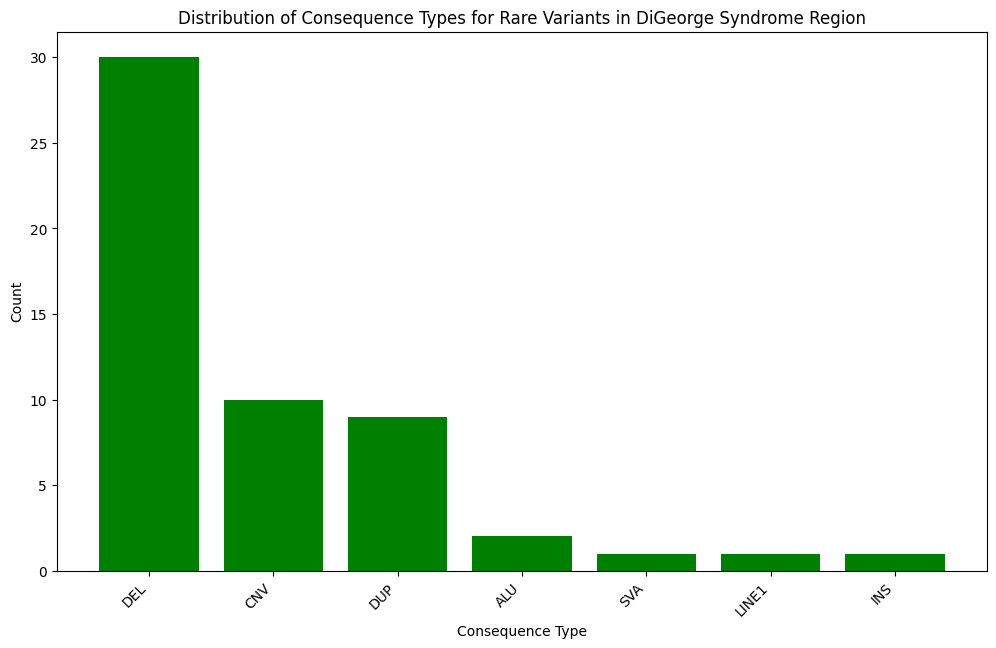

In [68]:
consequence_counts = rare_variants_df.groupBy("INFO_SVTYPE").count().orderBy("count", ascending=False)
consequence_counts = consequence_counts.dropna(subset=["INFO_SVTYPE"])  # Add this line to drop rows with missing values
labels, values = zip(*consequence_counts.collect())

plt.figure(figsize=(12, 7))
plt.bar(labels, values, color='green')
plt.title('Distribution of Consequence Types for Rare Variants in DiGeorge Syndrome Region')
plt.xlabel('Consequence Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.show()

#Free memory
consequence_counts = None
labels = None
values = None

The bar chart above illustrates the distribution of structural variation types among rare variants in the 22q11.2 region. The most common type of structural variation is **DEL** (deletions), with 30 occurrences, followed by **CNV** (copy number variations) and **DUP** (duplications). These types of variations could have significant implications for the function of genes in this region, particularly deletions, which are often associated with the loss of genetic material and potentially critical gene functions.

Interestingly, we also observe the presence of mobile elements like **ALU**, **LINE1**, and **SVA**, though their occurrence is quite low. These elements can disrupt normal gene function by inserting themselves into new genomic locations, which may contribute to genomic instability.

The data reveals that deletions are the predominant structural variation in this region, which aligns with the known association of large deletions in 22q11.2 with DiGeorge Syndrome.


Now I plot a scatter plot to visualize the distribution of rare variants along Chromosome 22. Each point in the scatter plot represents a variant, with its position on the x-axis corresponding to its location along the chromosome, and the y-axis representing the allele frequency of the variant.

By plotting the variants in this way, I aim to observe any patterns in their distribution along the chromosome. Specifically, I'm interested in identifying whether certain regions of Chromosome 22 show a higher concentration of rare variants or exhibit higher allele frequencies.


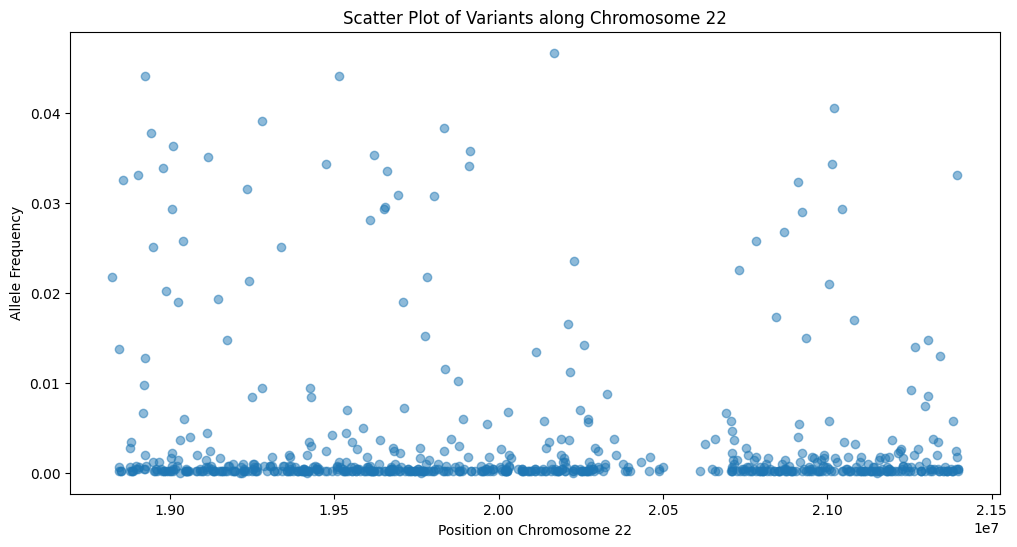

In [66]:
pos, allele_freqs = zip(*rare_variants_df.select("start", "AlleleFreq").sample(False, 0.01).collect())

plt.figure(figsize=(12, 6))
plt.scatter(pos, allele_freqs, alpha=0.5)
plt.title('Scatter Plot of Variants along Chromosome 22')
plt.xlabel('Position on Chromosome 22')
plt.ylabel('Allele Frequency')
plt.show()

The scatter plot displays the distribution of rare variants along Chromosome 22 based on their allele frequency. As expected, most variants have low allele frequencies, which is characteristic of rare variants. However, the plot also reveals clusters of variants with higher allele frequencies scattered throughout the region.

Notably, there are gaps in the distribution, which could suggest regions with fewer variants or regions that are not well covered in the dataset. These gaps may warrant further investigation to determine if they are biologically significant or simply due to limitations in the data.

Overall, this plot helps us visualize how rare variants are distributed across the chromosome and highlights regions that may be of interest for further genetic analysis related to DiGeorge Syndrome.


### Population-Specific Allele Frequency Analysis

In this section, I will explore the distribution of allele frequencies for rare variants across different populations. By comparing the allele frequencies in various populations, I aim to identify patterns that may suggest population-specific genetic variations, which could be relevant for understanding genetic susceptibility to DiGeorge Syndrome.

The dataset provides allele frequency information for multiple populations, including:
- **African Population (INFO_AFR_AF)**
- **European Population (INFO_EUR_AF)**
- **South Asian Population (INFO_SAS_AF)**
- **American Population (INFO_AMR_AF)**
- **East Asian Population (INFO_EAS_AF)**

In [73]:
# Extract the first element from each array of allele frequencies
rare_variants_df = rare_variants_df.withColumn("AFR_AF", col("INFO_AFR_AF").getItem(0)) \
                                   .withColumn("EUR_AF", col("INFO_EUR_AF").getItem(0)) \
                                   .withColumn("SAS_AF", col("INFO_SAS_AF").getItem(0)) \
                                   .withColumn("AMR_AF", col("INFO_AMR_AF").getItem(0)) \
                                   .withColumn("EAS_AF", col("INFO_EAS_AF").getItem(0))

# Now, describe the allele frequencies statistics for each population
rare_variants_df.select("AFR_AF", "EUR_AF", "SAS_AF", "AMR_AF", "EAS_AF").describe().show()



+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|              AFR_AF|              EUR_AF|              SAS_AF|              AMR_AF|              EAS_AF|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|               65803|               65803|               65803|               65803|               65803|
|   mean|0.006263263073111962|0.001849209002629...|0.002554394176557...|0.002169126027688...|0.002240729146087...|
| stddev|0.022824309293844738| 0.01536782592464435| 0.01707433112761003|0.015123297737948975|0.016456160689566242|
|    min|                 0.0|                 0.0|                 0.0|                 0.0|                 0.0|
|    max|              0.9902|                 1.0|                 1.0|              0.9986|                 1.0|
+-------+--------------------+--------------------+--------------------+--------

- **Count**: All columns contain 65,803 data points, indicating that the dataset is complete with no missing values for these populations.

- **Mean**:
  - The mean allele frequencies across populations are relatively low, ranging from 0.0018 (EUR_AF) to 0.0062 (AFR_AF). This suggests that, on average, most alleles in this dataset are rare in the populations studied.
  - The African population (AFR_AF) exhibits a higher mean allele frequency compared to other populations, which could indicate greater genetic diversity in the African population.

- **Standard Deviation (stddev)**:
  - The standard deviation is also relatively low but indicates variability in allele frequencies. Populations like AFR_AF and EAS_AF show slightly higher variability, which suggests a broader range of allele frequencies compared to the EUR_AF population, which shows lower variability.
  
- **Minimum (min)**:
  - The minimum value of 0.0 in all populations means that there are alleles absent (not present at all) in certain individuals or groups within each population.

- **Maximum (max)**:
  - The maximum allele frequency reaches values close to 1 in all populations, meaning that some alleles are nearly or completely fixed (present in all individuals) in those populations.
  - Interestingly, the maximum allele frequency in the AFR_AF population is slightly lower (0.9902) compared to the full 1.0 observed in EUR_AF, SAS_AF, and EAS_AF populations. This could reflect the greater genetic variation typically seen in African populations.


Given that the majority of allele frequencies are extremely low (close to zero), it is challenging to interpret the data without additional filtering. To address this, I'll filter out variants with an allele frequency of 0 to focus on those that show variation between populations.

Doing this, we can better understand the distribution of rare variants that actually occur in the population, which might provide insights into population-specific genetic variations.


In [ ]:
# Function to collect and filter allele frequencies
def get_filtered_freqs(population_column):
    freqs = [row[0] for row in rare_variants_df.select(population_column).dropna().collect()]
    return list(filter(lambda x: x > 0, freqs))

# Collect and filter frequencies for each population
afr_freqs_filtered = get_filtered_freqs("AFR_AF")
eur_freqs_filtered = get_filtered_freqs("EUR_AF")
sas_freqs_filtered = get_filtered_freqs("SAS_AF")
amr_freqs_filtered = get_filtered_freqs("AMR_AF")
eas_freqs_filtered = get_filtered_freqs("EAS_AF")

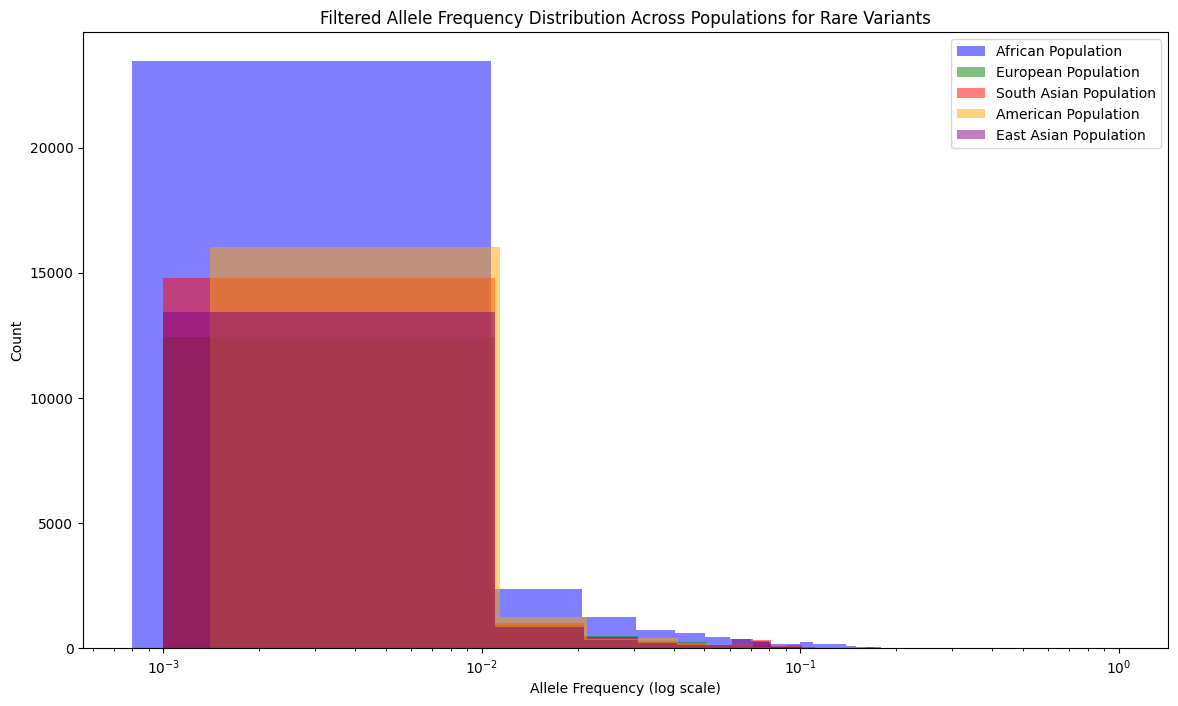

In [76]:
#Plot histograms
plt.figure(figsize=(14, 8))
plt.hist(afr_freqs_filtered, bins=100, alpha=0.5, label='African Population', color='blue')
plt.hist(eur_freqs_filtered, bins=100, alpha=0.5, label='European Population', color='green')
plt.hist(sas_freqs_filtered, bins=100, alpha=0.5, label='South Asian Population', color='red')
plt.hist(amr_freqs_filtered, bins=100, alpha=0.5, label='American Population', color='orange')
plt.hist(eas_freqs_filtered, bins=100, alpha=0.5, label='East Asian Population', color='purple')

plt.xscale('log')
plt.title('Filtered Allele Frequency Distribution Across Populations for Rare Variants')
plt.xlabel('Allele Frequency (log scale)')
plt.ylabel('Count')
plt.legend()
plt.show()


The histogram shows the distribution of allele frequencies for rare variants across five different populations: African, European, South Asian, American, and East Asian. After filtering out the variants with a frequency of 0, we can see that most rare variants still have very low frequencies, with the majority clustering in the range of 10⁻³ to 10⁻² across all populations.

The African population (violet) appears to have the highest number of variants with slightly higher allele frequencies, suggesting that there might be more variation in this population compared to others. The South Asian and American populations also show some frequency peaks, while the European and East Asian populations show fewer rare variants with higher frequencies.

This distribution reflects the fact that rare variants are mostly population-specific and tend to be uncommon across multiple populations. The slight differences in frequency distributions between populations may point to unique genetic adaptations or demographic histories.
